# ***Connecting the google drive to the code to use the saved pictures***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Unzip the dataset to teh currrent locations***

In [ ]:
# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "/content/drive/MyDrive/Calib_new.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')


File Name                                             Modified             Size
Calib_new/                                     2025-01-15 11:02:02            0
Calib_new/A1-r/                                2025-01-15 10:45:40            0
Calib_new/A1-r/Capture1.JPG                    2025-01-15 10:43:28        17966
Calib_new/A1-r/Capture2.JPG                    2025-01-15 10:43:54        16671
Calib_new/A1-r/Capture3.JPG                    2025-01-15 10:44:18        20121
Calib_new/A1-r/Capture4.JPG                    2025-01-15 10:44:48        14402
Calib_new/A1-r/Capture5.JPG                    2025-01-15 10:45:40        11252
Calib_new/A2-r/                                2025-01-15 11:00:24            0
Calib_new/A2-r/Capture1_A2.JPG                 2025-01-15 10:46:26        13942
Calib_new/A2-r/Capture2_A2.JPG                 2025-01-15 10:46:50         8623
Calib_new/A2-r/Capture3_A2.JPG                 2025-01-15 10:47:08        12554
Calib_new/A2-r/Capture4_A2.JPG          

# ***Importing the libraries for runing the code***

In [ ]:
import numpy as np
import cv2
import glob
import yaml

# ***Cloning the github code to run it for the extrinsic and intrinsic analysis***

In [ ]:
!git clone https://github.com/nuwandda/Checkerboard-Calibration.git

fatal: destination path 'Checkerboard-Calibration' already exists and is not an empty directory.


# ***Changing the directory to the checkerboard calibration path ***

In [ ]:
cd Checkerboard-Calibration/

# ***Importing library for runing the codes***

In [ ]:
import corner_detection as cd
import homography_operations as ho
import intrinsic_estimation as intr
import extrinsic_estimation as extr
import distortion_estimation as de
import parameter_refinement as pr
import visualize
import analysis
import logging
import util
import pathlib
import util

# ***Installing the exact matplotlibpyplot version for showing the extrinsic analysis***

In [ ]:
!pip install matplotlib==3.3.0

# ***Printing the code for the intrinsic analysis function***

In [ ]:
def main_intrinsic():
    pathlib.Path('graphs/').mkdir(parents=True, exist_ok=True)
    obj_points, img_points, img_shapes, img_names = cd.find_corners()

    refined_homographies = []
    for index in range(len(img_points)):
        util.info("Image Count: " + str(index + 1))
        h = ho.create_homography(img_points[index], obj_points[index])
        util.info("Homography:\n" + str(h) + "\n")
        h = ho.refine_homography(h, img_points[index], obj_points[index])
        util.info("Refined Homography:\n" + str(h) + "\n")
        refined_homographies.append(h)
        # analysis.plot_differences(img_points[index], obj_points[index], h, str(index + 1))

    A = intr.compute_intrinsics(refined_homographies)
    util.info("Camera Intrinsics:\n" + str(A) + "\n")

    # Once A is known, the extrinsic parameters for each image is readily computed.
    extrinsics = []
    for h_index in range(len(refined_homographies)):
        E = extr.compute_extrinsics(A, refined_homographies[h_index])
        util.info("Camera Extrinsic Matrix For Image-" + str(h_index + 1) + ":\n" + str(E) + "\n")
        extrinsics.append(E)

    # As the radial distortion is expected to be small, one would expect to estimate the other five intrinsic parameters,
    # using the Maximum likelihood estimation, reasonable well by simply ignoring distortion. One strategy is then to estimate
    # k1 and k2 after having estimated the other parameters, which will give us the ideal pixel coordinates.
    k = de.estimate_radial_distortion(obj_points, img_points, A, extrinsics)
    util.info("Radial Distortion: \n" + str(k) + "\n")

    K_opt, k_opt, extrinsics_opt  = pr.refine(A, k, extrinsics, obj_points, img_points)
    util.info("Parameters:")
    print('\t   Focal Length: [ {:.5f}  {:.5f} ]'.format(K_opt[0,0], K_opt[1,1]))
    print('\tPrincipal Point: [ {:.5f}  {:.5f} ]'.format(K_opt[0,2], K_opt[1,2]))
    print('\t           Skew: [ {:.7f} ]'.format(K_opt[0,1]))
    print('\t     Distortion: [ {:.6f}  {:.6f} ]'.format(k_opt[0], k_opt[1]))



# ***Runin the extrinsic analysis for the work***

In [ ]:
if __name__ == "__main__":
    logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
    main_intrinsic()

	   Focal Length: [ 3660.25174  3619.33126 ]
	Principal Point: [ 1257.49723  695.93659 ]
	           Skew: [ 140.9285210 ]
	     Distortion: [ -0.122022  -1.944025 ]


# ***Runing the code for extrinsic analysis and providing the function***

In [ ]:
def main_extrinsic():
    pathlib.Path('graphs/').mkdir(parents=True, exist_ok=True)
    obj_points, img_points, img_shapes, img_names = cd.find_corners()
    refined_homographies = []
    for index in range(len(img_points)):
        util.info("Image Count: " + str(index + 1))
        h = ho.create_homography(img_points[index], obj_points[index])
        util.info("Homography:\n" + str(h) + "\n")
        h = ho.refine_homography(h, img_points[index], obj_points[index])
        util.info("Refined Homography:\n" + str(h) + "\n")
        refined_homographies.append(h)
        # analysis.plot_differences(img_points[index], obj_points[index], h, str(index + 1))

    A = intr.compute_intrinsics(refined_homographies)
    util.info("Camera Intrinsics:\n" + str(A) + "\n")

    # Once A is known, the extrinsic parameters for each image is readily computed.
    extrinsics = []
    for h_index in range(len(refined_homographies)):
        E = extr.compute_extrinsics(A, refined_homographies[h_index])
        util.info("Camera Extrinsic Matrix For Image-" + str(h_index + 1) + ":\n" + str(E) + "\n")
        extrinsics.append(E)
    k = de.estimate_radial_distortion(obj_points, img_points, A, extrinsics)
    util.info("Radial Distortion: \n" + str(k) + "\n")

    K_opt, k_opt, extrinsics_opt  = pr.refine(A, k, extrinsics, obj_points, img_points)
    util.info("Parameters:")
    util.info("Projection Matrices for WebGL:\n")
    print("Projection Matrices for WebGL")
    znear, zfar = .1, 1000.
    for idx, e in enumerate(extrinsics_opt):
        p = util.get_camera_matrix(K_opt, e)
        util.info("P matrix for image " + str(idx + 1) + ":\n" + str(p))
        decomposed_p = util.decompose(p)
        print("P matrix for image")
        webgl_p = util.to_opengl_projection(decomposed_p['intrinsic'], 0, 0, img_shapes[idx][0], img_shapes[idx][1], znear, zfar, direction="y down")
        print("webgl_p")
        util.info("P matrix(WebGl) for image " + str(idx + 1) + ":\n" + str(webgl_p))
        print("P matrix(WebGl) for image")

    visualize.visualize_camera_frame(obj_points[0], extrinsics_opt[0], img_names[0])


# ***Runing the code for geting the rotations and transportations matrixes ***

In [ ]:
import numpy as np
import cv2
import util


def compute_extrinsics(A, homography):
    util.info("Computing extrinsic parameters...")
    h1 = util.column(homography, 0)
    h2 = util.column(homography, 1)
    h3 = util.column(homography, 2)

    A_inv = np.linalg.inv(A)

    # We have lambda defined in the page 6. h1, h2 or h3 can be used in the calculation of lambda.
    lmbda = 1. / np.linalg.norm(np.dot(A_inv, h1))

    # Compute r1, r2, r3 and t with the values given above.
    r1 = lmbda * np.dot(A_inv, h1)
    r2 = lmbda * np.dot(A_inv, h2)
    # r3 can be calculated with the orthogonality between r1 and r2.
    r3 = np.cross(r1, r2)
    t = lmbda * np.dot(A_inv, h3)

    # Reconstitute the rotation component of the extrinsics and reorthogonalize.
    # R = [r1, r2, r3]
    R = np.vstack((r1, r2, r3)).T
    R = util.reorthogonalize(R)
    print("The revelotion for the extrinsic matrix is: ", R)
    print("The transformer matrix for the extrinsic analysis", t[:, np.newaxis])
    # Reconstitute full extrinsics
    E = np.hstack((R, t[:, np.newaxis]))
    util.info("DONE.")

    return E, R,  t[:, np.newaxis]

In [ ]:
pathlib.Path('graphs/').mkdir(parents=True, exist_ok=True)
obj_points, img_points, img_shapes, img_names = cd.find_corners()
refined_homographies = []
for index in range(len(img_points)):
    util.info("Image Count: " + str(index + 1))
    h = ho.create_homography(img_points[index], obj_points[index])
    util.info("Homography:\n" + str(h) + "\n")
    h = ho.refine_homography(h, img_points[index], obj_points[index])
    util.info("Refined Homography:\n" + str(h) + "\n")
    refined_homographies.append(h)
    # analysis.plot_differences(img_points[index], obj_points[index], h, str(index + 1))

A = intr.compute_intrinsics(refined_homographies)
util.info("Camera Intrinsics:\n" + str(A) + "\n")

# Once A is known, the extrinsic parameters for each image is readily computed.
extrinsics = []
for h_index in range(len(refined_homographies)):
    E = extr.compute_extrinsics(A, refined_homographies[h_index])
    util.info("Camera Extrinsic Matrix For Image-" + str(h_index + 1) + ":\n" + str(E) + "\n")
    extrinsics.append(E)
k = de.estimate_radial_distortion(obj_points, img_points, A, extrinsics)
util.info("Radial Distortion: \n" + str(k) + "\n")
K_opt, k_opt, extrinsics_opt  = pr.refine(A, k, extrinsics, obj_points, img_points)
util.info("Parameters:")
util.info("Projection Matrices for WebGL:\n")
print("Projection Matrices for WebGL")
znear, zfar = .1, 1000.

Projection Matrices for WebGL


In [ ]:
R_t, T_t = np.zeros((3,3)), np.zeros((3,1))
for h_index in range(len(refined_homographies)):
    E, R, T = compute_extrinsics(A, refined_homographies[h_index])
    R_t+= R
    T_t+= T
    util.info("Camera Extrinsic Matrix For Image-" + str(h_index + 1) + ":\n" + str(E) + "\n")


The revelotion for the extrinsic matrix is:  [[ 0.07626422 -0.99106007  0.10947012]
 [ 0.77690783  0.12788082  0.61649065]
 [-0.6249784   0.03803201  0.77971506]]
The transformer matrix for the extrinsic analysis [[ 0.00645732]
 [-0.05716956]
 [ 0.55290515]]
The revelotion for the extrinsic matrix is:  [[ 0.0557213   0.94307188 -0.32788804]
 [-0.91717564  0.17812405  0.35645571]
 [ 0.3945681   0.28086875  0.87488786]]
The transformer matrix for the extrinsic analysis [[-0.09011888]
 [ 0.13113412]
 [ 0.54932763]]
The revelotion for the extrinsic matrix is:  [[-0.98463106  0.05745545  0.16492589]
 [ 0.08976727 -0.64355342  0.76011896]
 [ 0.1498116   0.76324168  0.62850506]]
The transformer matrix for the extrinsic analysis [[0.09337546]
 [0.01815821]
 [0.43999233]]
The revelotion for the extrinsic matrix is:  [[ 0.76411972  0.39022426 -0.5136595 ]
 [-0.01205848  0.80478096  0.59344941]
 [ 0.64496174 -0.44727245  0.61965451]]
The transformer matrix for the extrinsic analysis [[-0.10743328

In [ ]:
print("The average rotations over all pictures: ", R_t/19)

The average rotations over all pictures:  [[-0.0126365   0.26873036 -0.05893611]
 [-0.23194018  0.10050067  0.25559518]
 [ 0.11977388  0.02880981  0.61499587]]


In [ ]:
print("The average transformation over all pictures: ", T_t/19)

The average transformation over all pictures:  [[-0.03636979]
 [ 0.03707577]
 [ 0.48344176]]


# ***runing the code for the reaching to extrinsic analysis***

In [ ]:
for idx, e in enumerate(extrinsics_opt):
  p = util.get_camera_matrix(K_opt, e)
  util.info("P matrix for image " + str(idx + 1) + ":\n" + str(p))
  decomposed_p = util.decompose(p)
  print("P matrix for image")
  webgl_p = util.to_opengl_projection(decomposed_p['intrinsic'], 0, 0, img_shapes[idx][0], img_shapes[idx][1], znear, zfar, direction="y down")
  print("webgl_p")
  util.info("P matrix(WebGl) for image " + str(idx + 1) + ":\n" + str(webgl_p))
  print("P matrix(WebGl) for image")

P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image
P matrix for image
webgl_p
P matrix(WebGl) for image


# ***Checking the results of extrinsic analysis***

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np
import util
from matplotlib import rc
from matplotlib.ticker import MultipleLocator


# From https://dawes.wordpress.com/2014/06/27/publication-ready-3d-figures-from-matplotlib/
rc('font', size=10)
rc('font', family='serif')
rc('axes', labelsize=10)
rc('lines', markersize=5)
rc('lines', markeredgewidth=10)


def make_axis_publishable(ax, major_x, major_y, major_z):
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

    ax.xaxis.set_major_locator(MultipleLocator(major_x))
    ax.yaxis.set_major_locator(MultipleLocator(major_y))
    ax.zaxis.set_major_locator(MultipleLocator(major_z))


def visualize_camera_frame(model, extrinsic, img_name):
    util.info("Visualizing " + str(img_name) + ".jpg...")
    print("Visualizing")
    model = util.to_homogeneous_3d_multiple_points(model)
    print("model")
    fig = plt.figure()
    print("fig")
    ax = fig.add_subplot('111', projection='3d')
    print("add_subplot")
    make_axis_publishable(ax, 20, 20, 20)
    print("Camera-Centric Extrinsic")
    ax.set_title('Camera-Centric Extrinsic')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(0, 20)

    # From StackOverflow: https://stackoverflow.com/questions/39408794/python-3d-pyramid
    v = np.array([[-0.5, -0.5, 1], [0.5, -0.5, 1],
                 [0.5, 0.5, 1],  [-0.5, 0.5, 1], [0, 0, 0]])

    verts = [[v[0], v[1], v[4]], [v[0], v[3], v[4]],
     [v[2], v[1], v[4]], [v[2], v[3], v[4]], [v[0], v[1], v[2], v[3]]]

    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    model_ext = np.dot(model, extrinsic.T)
    print("np.dot")
    xs = model_ext[:,0] * 40
    ys = model_ext[:,1] * 40
    zs = model_ext[:,2] * 20

    ax.plot_trisurf(xs, ys, zs)
    print("plot_trisurf")
    ax.invert_xaxis()

    util.info("Saving graph...")
    plt.savefig("graphs/camera_centric.png")
    plt.show()
    plt.clf()
    util.info("DONE.")


Visualizing
model
fig
add_subplot
Camera-Centric Extrinsic
np.dot
plot_trisurf


<ipython-input-14-87365cdfb244>:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot('111', projection='3d')


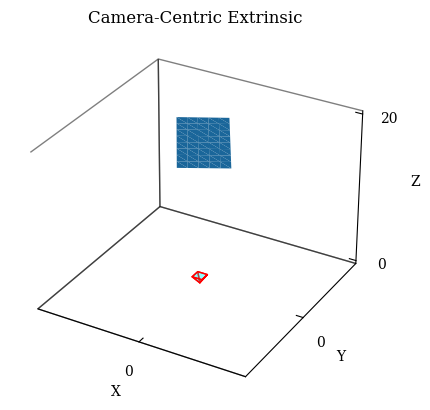

<Figure size 640x480 with 0 Axes>

In [ ]:
visualize_camera_frame(obj_points[1], extrinsics_opt[1], img_names[1])